Para Verificar Performance da GPU Usar o Comando:

watch -n 1 amd-smi

# Setup do Projeto

In [1]:
import torch

# Setup Agnostic Code for GPU/CPU
if torch.cuda.is_available():
    device = 'cuda'
    print(f"CUDA está disponivel!\nDispositivo configurado para: {device}\nDevice count: {torch.cuda.device_count()}\nNome do dispositivo: {torch.cuda.get_device_name(0)}\nVersao do PyTorch: {torch.__version__}")
else:
    device = 'cpu'
    print(f"CUDA não está disponível.\nDispositivo configurado para: {device}\nVersao do PyTorch: {torch.__version__}")

CUDA está disponivel!
Dispositivo configurado para: cuda
Device count: 2
Nome do dispositivo: AMD Radeon RX 7800 XT
Versao do PyTorch: 2.9.1+rocm7.2.0.git7e1940d4


In [2]:
# Constantes
import os

DATA_PATH = '/home/jose-vitor/Documents/Cityscapes_Dataset'

IM_HEIGHT = 256
IM_WIDTH = 512

BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count() // 2

NUM_CLASSES = 19

In [3]:
# Bibliotecas e imports
import custom_cityscapes as ccs
import custom_transforms as ctr
import linknet_model as lkm
import train as tr
from utils import dataset_show

from torchvision import datasets
from torch.utils.data import DataLoader
from torchinfo import summary

# Preparando o Dataset Cityscapes

In [4]:
ds_lables = ccs.CityscapesLables()

# Imprimindo informacoes relevantes
print(f"O dataset possui {len(ds_lables.id_names)} classes treinaveis:")
ds_lables.id_names

O dataset possui 20 classes treinaveis:


{0: 'road',
 1: 'sidewalk',
 2: 'building',
 3: 'wall',
 4: 'fence',
 5: 'pole',
 6: 'traffic light',
 7: 'traffic sign',
 8: 'vegetation',
 9: 'terrain',
 10: 'sky',
 11: 'person',
 12: 'rider',
 13: 'car',
 14: 'truck',
 15: 'bus',
 16: 'train',
 17: 'motorcycle',
 18: 'bicycle',
 19: 'ignore'}

In [5]:
# Imprimir o dictionário de mapeamento de ids originais para ids de treino
print("\nDicionário de mapeamento de ids originais para ids de treino:")
ds_lables.lable_conversion


Dicionário de mapeamento de ids originais para ids de treino:


{0: 19,
 1: 19,
 2: 19,
 3: 19,
 4: 19,
 5: 19,
 6: 19,
 7: 0,
 8: 1,
 9: 19,
 10: 19,
 11: 2,
 12: 3,
 13: 4,
 14: 19,
 15: 19,
 16: 19,
 17: 5,
 18: 19,
 19: 6,
 20: 7,
 21: 8,
 22: 9,
 23: 10,
 24: 11,
 25: 12,
 26: 13,
 27: 14,
 28: 15,
 29: 19,
 30: 19,
 31: 16,
 32: 17,
 33: 18}

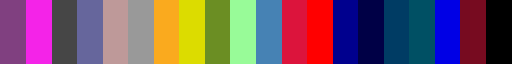

In [6]:
# Criando o colormap para as classes
cmap = ds_lables.get_cmap()
cmap

# Importar o Dataset Cityscapes

Definir Funções de Transform

In [7]:
custom_trans = ctr.Transforms(conv_size=(IM_HEIGHT, IM_WIDTH),
                              lable_conversion=ds_lables.lable_conversion)

Importar Dataset

In [8]:
train_dataset = ccs.AugmentedCityscapes(DATA_PATH,
                             split = 'train',
                             mode='fine',
                             target_type='semantic',
                             transform=custom_trans.train_transform,
                             target_transform=custom_trans.target_transform,
                             data_augmentation=custom_trans.data_augmentation)
val_dataset = datasets.Cityscapes(DATA_PATH,
                           split = 'val',
                           mode='fine',
                           target_type='semantic',
                           transform=custom_trans.val_transform,
                           target_transform=custom_trans.target_transform)
test_dataset = datasets.Cityscapes(DATA_PATH,
                            split = 'test',
                            mode='fine',
                            target_type='semantic',
                            transform=custom_trans.val_transform,
                            target_transform=custom_trans.target_transform)

In [9]:
# Imprimir informacoes importantes dos datasets
img, smnt = train_dataset[0]
print(f"O Dataset de treino possui {len(train_dataset)} amostras.\n"
      f"O Dataset de validação possui {len(val_dataset)} amostras.\n"
      f"O Dataset de teste possui {len(test_dataset)} amostras.\n"
      f"Cada imagem posssui tamanho {img.shape} e tipo {img.dtype}, e cada mascara possui tamanho {smnt.shape} e tipo {smnt.dtype}.\n")

#print(f"Primeira Imagem do dataset de treino:\n{img}\nPrimenra mascara do dataset de treino:\n{smnt}")

O Dataset de treino possui 2975 amostras.
O Dataset de validação possui 500 amostras.
O Dataset de teste possui 1525 amostras.
Cada imagem posssui tamanho torch.Size([3, 256, 512]) e tipo torch.float32, e cada mascara possui tamanho torch.Size([256, 512]) e tipo torch.uint8.



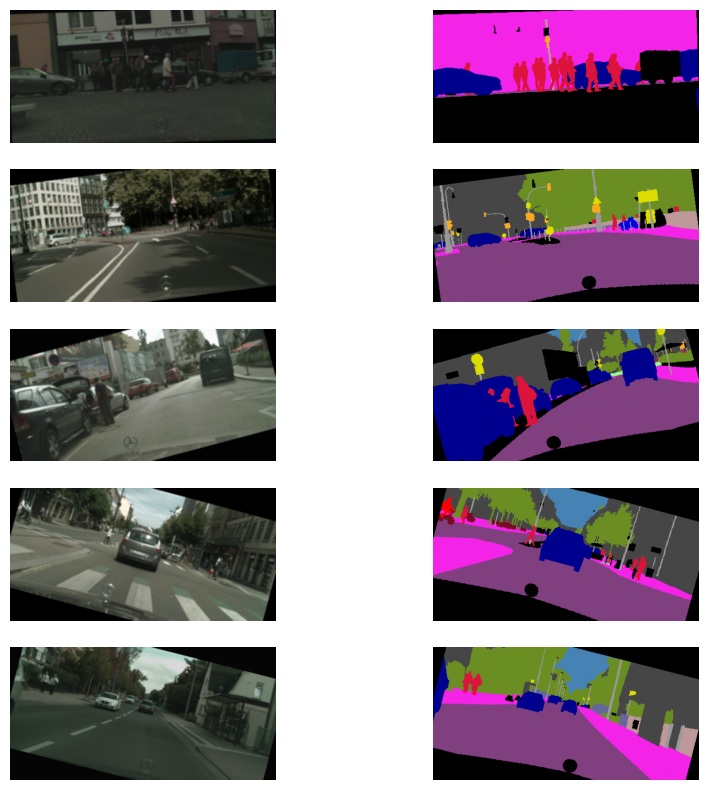

In [10]:
# Testando a funcao de exibicao
dataset_show(train_dataset, n=5, cmap=cmap)

Criar dataloaders

In [11]:
# Criando datalaoders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True, pin_memory=True)

In [12]:
# Imprimindo informacoes relevantes dos dataloaders
train_features_batch, train_labels_batch = next(iter(train_dataloader))
val_features_batch, val_labels_batch = next(iter(val_dataloader))
print(f"O pacote de imagens para treino possui tamanho: {train_features_batch.size()}, e o tamanho do pacote da mescaras para treino possui tamanho: {train_labels_batch.size()}")
print(f"O pacote de imagens para validacao possui tamanho: {val_features_batch.size()}, e o tamanho do pacote da mescaras para validacao possui tamanho: {val_labels_batch.size()}")

O pacote de imagens para treino possui tamanho: torch.Size([32, 3, 256, 512]), e o tamanho do pacote da mescaras para treino possui tamanho: torch.Size([32, 256, 512])
O pacote de imagens para validacao possui tamanho: torch.Size([32, 3, 256, 512]), e o tamanho do pacote da mescaras para validacao possui tamanho: torch.Size([32, 256, 512])


## Criar Modelo 

In [13]:
model = lkm.LinkNet(in_channels=3, out_channels=19).to(device)
summary(model, input_size=(BATCH_SIZE, 3, IM_HEIGHT, IM_WIDTH))

Layer (type:depth-idx)                   Output Shape              Param #
LinkNet                                  [32, 19, 256, 512]        --
├─Sequential: 1-1                        [32, 64, 64, 128]         --
│    └─Conv2d: 2-1                       [32, 64, 128, 256]        9,472
│    └─BatchNorm2d: 2-2                  [32, 64, 128, 256]        128
│    └─ReLU: 2-3                         [32, 64, 128, 256]        --
│    └─MaxPool2d: 2-4                    [32, 64, 64, 128]         --
├─LinkNetEncoderBlock: 1-2               [32, 64, 32, 64]          --
│    └─Sequential: 2-5                   [32, 64, 32, 64]          --
│    │    └─Conv2d: 3-1                  [32, 64, 32, 64]          4,160
│    │    └─BatchNorm2d: 3-2             [32, 64, 32, 64]          128
│    └─Sequential: 2-6                   [32, 64, 32, 64]          --
│    │    └─Conv2d: 3-3                  [32, 64, 32, 64]          36,928
│    │    └─BatchNorm2d: 3-4             [32, 64, 32, 64]          128
│ 

In [14]:
# Testar Modelo com uma imagem do dataset
test_input = train_dataset[0][0].unsqueeze(0).to(device) # Adiciona uma dimensão de batch e move para o dispositivo
test_output = model(test_input)
print(f"Tamanho da entrada: {test_input.shape}\n"
      f"Tamanho da saida: {test_output.shape}")

Tamanho da entrada: torch.Size([1, 3, 256, 512])
Tamanho da saida: torch.Size([1, 19, 256, 512])


In [15]:
# testar softmax e argmax
test_output_softmax = torch.softmax(test_output, dim=1).argmax(dim=1)
print(f"O tamanho do output apos softmax e argmax eh: {test_output_softmax.shape}")
test_output_softmax

O tamanho do output apos softmax e argmax eh: torch.Size([1, 256, 512])


tensor([[[10, 15,  5,  ...,  7,  5,  7],
         [ 1, 14,  1,  ...,  4, 18,  1],
         [10, 17,  0,  ..., 17,  5, 13],
         ...,
         [ 7, 18,  5,  ..., 10,  7, 16],
         [10,  7,  8,  ...,  9, 10, 16],
         [ 3,  4, 18,  ...,  4, 18,  1]]], device='cuda:0')

## Treinar Modelo

In [16]:
# Treinar o modelo
fit_model = tr.TrainLinkNet(model=model, device=device, epochs=5)
fit_model(train_dataloader, val_dataloader)

Epoch 1/5


  0%|          | 0/93 [00:00<?, ?it/s]

Kernel Name: _ZN2at6native12_GLOBAL__N_125nll_loss2d_forward_kernelIffiEEvPT_S4_PKS3_PKlS6_iiil
VGPU=0x26297100 SWq=0x72aef1de4000, HWq=0x72ae03000000, id=1
	Dispatch Header =0xb02 (type=2, barrier=1, acquire=1, release=1), setup=0
	grid=[32768, 1, 1], workgroup=[1024, 1, 1]
	private_seg_size=0, group_seg_size=8192
	kernel_obj=0x72ae04deaf00, kernarg_address=0x0x72aca021d580
	completion_signal=0x0, correlation_id=0
	rptr=857, wptr=860
 

:0:rocdevice.cpp            :3586: 44071321365 us:  Callback: Queue 0x72ae03000000 aborting with error : HSA_STATUS_ERROR_EXCEPTION: An HSAIL operation resulted in a hardware exception. code: 0x1016
/home/jose-vitor/Documents/pytorch_projects/linknet/linknet-studynotes/train.py:52: UserWarning: HIP warning: unspecified launch failure (Triggered internally at /pytorch/aten/src/ATen/hip/impl/HIPGuardImplMasqueradingAsCUDA.h:83.)
  train_loss += batch_loss.cpu().item() # Accumulate the scalar value for reporting


AcceleratorError: HIP error: unspecified launch failure
Search for `hipErrorLaunchFailure' in https://docs.nvidia.com/cuda/cuda-runtime-api/group__HIPRT__TYPES.html for more information.
HIP kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing AMD_SERIALIZE_KERNEL=3
Compile with `TORCH_USE_HIP_DSA` to enable device-side assertions.


## Plotar Resultdos

In [ ]:
from torchmetrics.classification import MulticlassJaccardIndex

In [ ]:
target = torch.tensor([[1, 0, 1, 2],
                       [2, 1, 0, 2],
                       [1, 1, 0, 2],
                       [0, 1, 2, 2]])
preds = torch.tensor([[0, 0, 1, 2],
                      [0, 1, 0, 2],
                      [1, 0, 0, 2],
                      [0, 1, 0, 2]])
metric = MulticlassJaccardIndex(num_classes=3, average='none')
metric(preds, target)

tensor([0.5000, 0.6667, 0.6667])

(<Figure size 640x480 with 1 Axes>, <Axes: ylabel='MulticlassJaccardIndex'>)

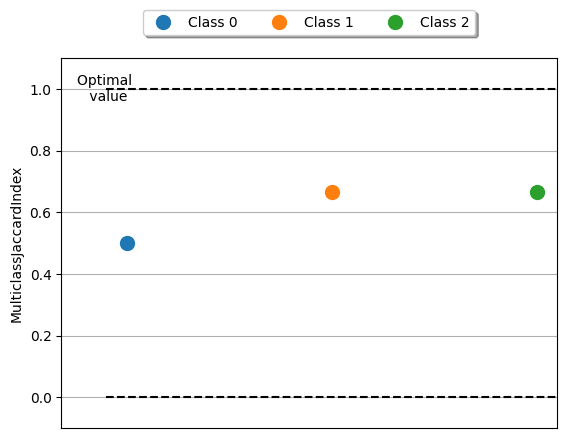

In [ ]:
metric.plot()